In [1]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import os
from scipy.misc import imread

In [2]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X,Y

x,y = load_CIFAR_batch("cifar-10-batches-py/data_batch_1")
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
(10000, 32, 32, 3)
(10000,)


In [3]:
def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [4]:
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [7]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_train = 49000
num_validation = 1000
num_test = 1000
num_dev = 100

mask = range(num_train, num_train + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = np.random.choice(num_train, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_train)
X_train = X_train[mask]
y_train = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (100, 3072)


In [10]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis = 0)

# second: subtract the mean image from train and test data
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (100, 3073)


In [14]:
def svm_loss_vectorized(W, X, y, reg):
    
    loss = 0.0
    dW = np.zeros(W.shape)
    num_train = X.shape[0]
    delta = 1.0
    scores = X.dot(W)
    correct_class_score = scores[np.arange(num_train), y]
#     print(correct_class_score.shape)
    # correct_class_score[:,np.newaxis] 把correct_class_score.shape = (N,) turn to correct_class_score[:,np.newaxis].shape = (N,1)
    margins = np.maximum(0, scores - correct_class_score[:, np.newaxis] + delta)
    margins[np.arange(num_train), y] = 0.0
    margins[margins < 0] = 0.0
    loss += np.sum(margins) / num_train
    loss += 0.5 * reg * np.sum(W * W)
    
    margins[margins > 0] = 1.0
    row_sum = np.sum(margins, axis=1)
    margins[np.arange(num_train), y] = - row_sum
    dW += np.dot(X.T, margins) / num_train + reg * W
  
  
    return loss, dW

In [12]:
class LinearClassifier(object):
    
    
    def __init__(self):
        self.W = None
        
        
    def train(self, X, y, learning_rate = 2e-7, reg = 2e4, num_iters = 100, batch_sie = 200, verbose = False):
        '''
            i won't loops for num_iters times i just to loop for one time to save time
        '''
        # get the value of the train_set and the classes
        num_train,dim = X.shape
        num_classes = np.max(y) + 1
        # initlization the weights
        if self.W == None:
            self.W = np.random.randn(dim, num_classes) * 0.001
            
        # initlization the list to append the loss every single loop
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            
            # random choice the num_iters data in the train_set
            mask = np.random.choice(num_train, num_iters, replace = True)
            X_batch = X[mask]
            y_batch = y[mask]
            
            # caculate the loss and the gradient
            loss,grad = self.loss(X, y, reg)
            loss_history.append(loss)
            
            # accoding the learning_rate to change the weights
            self.W = self.W - grad * learning_rate
            
            if verbose and it % 100 == 0:
                print('iteration %d / %d ,loss: %f' %(it, num_iters, loss))
            
        return loss_history, self.W
    
    
    def predict(self, X):
        
        # get the values of the X.shape[0] map to the y_pred
        num_train = X.shape[0]
        
        # caculate the scores to each class
        scores = X.dot(self.W)
        
        # initlization the y
        y_pred = np.zeros(num_train)
        
        # get the index of the max score means the class to predict
        y_pred = np.argsort(scores, axis=1)[:,-1]
        
        return y_pred
    
    def loss(self, X_batch, y_batch, reg):
        # let the subclass to override this function
        
        pass
    

class LinearSVM(LinearClassifier):
    
    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [15]:
svm = LinearSVM()
loss_hist,W = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500 ,loss: 806.169131
iteration 100 / 1500 ,loss: 292.146373
iteration 200 / 1500 ,loss: 109.591111
iteration 300 / 1500 ,loss: 43.193369
iteration 400 / 1500 ,loss: 19.057691
iteration 500 / 1500 ,loss: 10.281252
iteration 600 / 1500 ,loss: 7.086362
iteration 700 / 1500 ,loss: 5.922218
iteration 800 / 1500 ,loss: 5.497789
iteration 900 / 1500 ,loss: 5.342913
iteration 1000 / 1500 ,loss: 5.286365
iteration 1100 / 1500 ,loss: 5.265710
iteration 1200 / 1500 ,loss: 5.258162
iteration 1300 / 1500 ,loss: 5.255401
iteration 1400 / 1500 ,loss: 5.254391


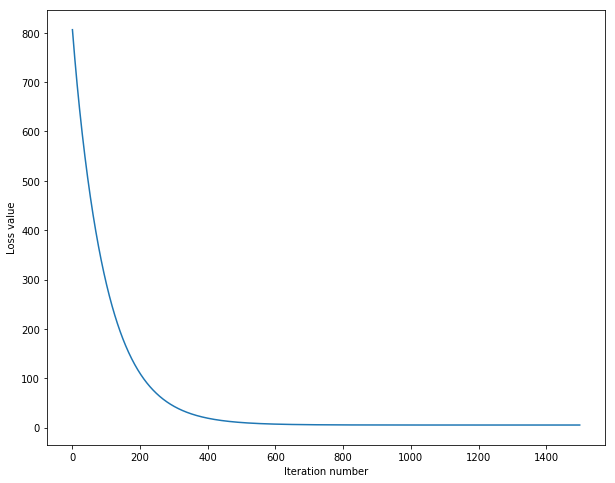

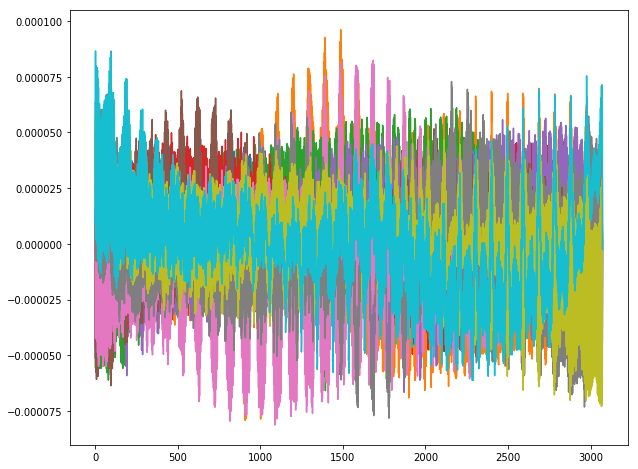

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()
plt.plot(W)
plt.show()

In [17]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.377449
validation accuracy: 0.382000
